In [55]:
#Imports
import numpy as np
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression as SklearnLogReg
from urllib.request import urlretrieve
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# Download datasets
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt" #Train Dataset of NSL-KDD Dataset
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"   #Test dataset of NSL-KDD Dataset

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(filename):
    print("Downloading 10% KDD Cup'99 dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(train_file):
    print("Downloading training dataset of NSL-KDD...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset of NSL-KDD...")
    urlretrieve(test_url, test_file)
# print('Datasets have been downloaded.')

In [59]:

#Custom Logistic Regression class
class LogisticRegression:
    def __init__(self, alpha=0.01, epochs=1000):
        self.alpha= alpha #Alpha is the learning rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) #SIgmoid function

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features) * 0.01   #Initialize weights randomly
        self.bias = 0

        for _ in tqdm(range(self.epochs), desc="Training Progress", unit="epoch"):
            # Compute linear combination
            linear_model = np.dot(X, self.weights) + self.bias  # =w.x + b
            y_pred = self.sigmoid(linear_model) #Applying sigmoid function

            # Compute gradients and apply gradient descent
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Updating weights
            self.weights -= self.alpha * dw
            self.bias -= self.alpha * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int) #Returns 0 or 1 depending on predict_probability




In [60]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [61]:
def calculateAndDisplayEvaluationMetrics(y_test, y_pred,title):
    accuracy = accuracy_score(y_test,y_pred)*100
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plot_confusion_matrix(y_test, y_pred, title)

In [62]:
# (a) KDD Cup '99

#defining columns 
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
df = df.drop_duplicates()  

print(df.shape)


(145586, 42)


In [64]:
print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a 
#Clearly, we can see that this daataset is very skewed and imbalanced

{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [65]:
#Preprocessing Data

# Convert categorical columns using Label Encoding (since, ML Models can only take in numerical features and not text)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Converting labels to binary, ie, 0 if normal and 1 if attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

X = df.drop("label", axis=1).values # Extracting features
y = df["label"].values #Extracting labels

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 80% train, 20% test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training Progress: 100%|██████████| 1000/1000 [00:11<00:00, 86.38epoch/s]


Model Accuracy: 97.63%
Precision: 0.9871
Recall: 0.9526
F1 Score: 0.9695


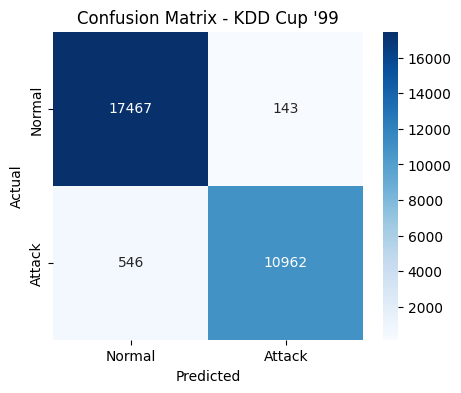

In [66]:
# Train the logistic regression model
log_reg = LogisticRegression(alpha=0.01, epochs=1000)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Compute accuracy
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix - KDD Cup '99" )




Model Accuracy: 98.83%
Precision: 0.9892
Recall: 0.9810
F1 Score: 0.9851


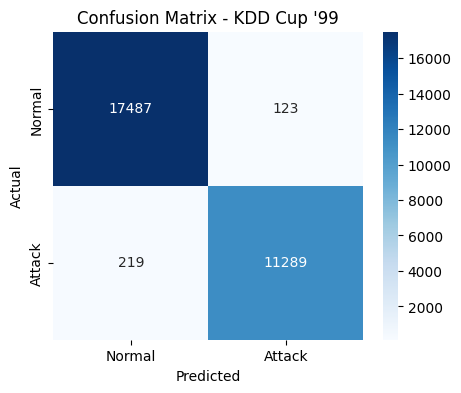

In [67]:
#Comparing with sklearn
log_reg = SklearnLogReg(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix - KDD Cup '99" )


In [68]:
#(b) ON the NSL-KDD Dataset
KDDNSL_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "class", "difficulty"
]

train_df = pd.read_csv(train_file, names=KDDNSL_columns, header=None)
test_df = pd.read_csv(test_file, names=KDDNSL_columns, header=None)

#Dropping the difficulty column as its irrelevant for training
train_df.drop("difficulty", axis=1, inplace=True)
test_df.drop("difficulty", axis=1, inplace=True)

print(train_df['class'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a 
#Clearly, we can see that this daataset is more balanced

# Label encode categorical columns(to convert features to numerical values)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()

for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])  # Fit + transform on train
    test_df[col] = encoder.transform(test_df[col])  # Transform only on test (NO FIT)

# Convert class labels to binary (0 for normal, 1 for attack)
train_df["class"] = train_df["class"].apply(lambda x: 0 if x == "normal" else 1)
test_df["class"] = test_df["class"].apply(lambda x: 0 if x == "normal" else 1)

# Split features and labels
X_train = train_df.drop("class", axis=1).values
y_train = train_df["class"].values
X_test = test_df.drop("class", axis=1).values
y_test = test_df["class"].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test) 

print(X_train.shape)
print(X_test.shape)



{'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2}
(125973, 41)
(22544, 41)


Training Progress: 100%|██████████| 1000/1000 [00:12<00:00, 81.24epoch/s]


Model Accuracy: 76.17%
Precision: 0.9254
Recall: 0.6323
F1 Score: 0.7513


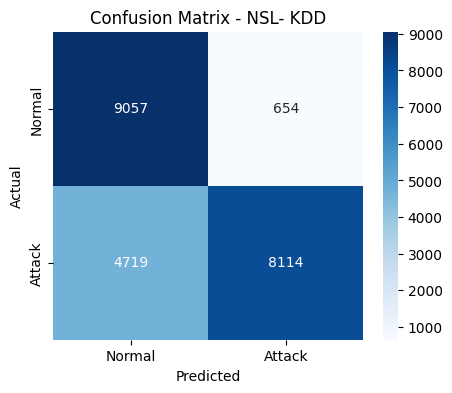

In [69]:
# Train the logistic regression model
log_reg = LogisticRegression(alpha=0.01, epochs=1000)
log_reg.fit(X_train, y_train)

# Make predictions(accuracy)
y_pred = log_reg.predict(X_test)

calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix - NSL- KDD")




Model Accuracy: 75.39%
Precision: 0.9252
Recall: 0.6175
F1 Score: 0.7407


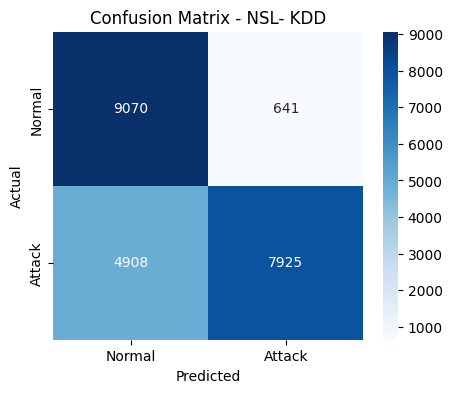

In [70]:
#Comparing with sklearn,

log_reg = SklearnLogReg(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

# Compute metrics
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix - NSL- KDD")